In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

In [2]:
# Nicer plotting
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = (8,4)

# Functional examplet for LUME-Impact

In [3]:
from impact import Impact, run_impact_with_distgen, evaluate_impact_with_distgen

from impact import template_dir

import os

In [4]:
gfile = os.path.join(template_dir, 'lcls_injector/distgen.yaml')
ifile = os.path.join(template_dir, 'lcls_injector/ImpactT.yaml')

# Functional run_impact_with_distgen

This is a functional way to apply some settings to and run distgen and impact together.

Any key with a prefix `disgten:` will send its suffix to distgen's Generator.

Otherwise, any key that can be set with Impact's attr syntax can be used.



<Impact with 100 particles, stopping at 0.02 m, at 0x7fc35191de90>

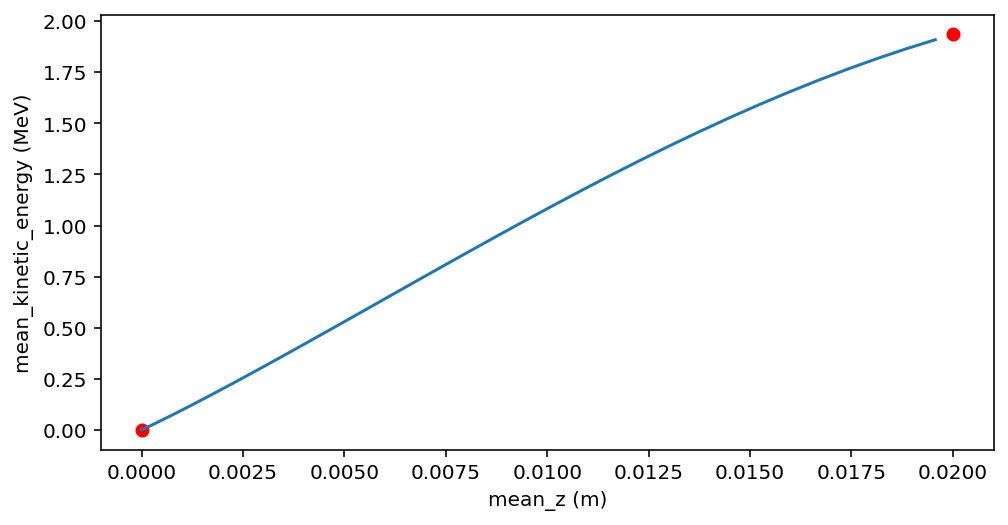

In [5]:
# Make some settings
SETTINGS0 = {
    'distgen:n_particle':100,
    'total_charge':0,  # effectively turns spacecharge off
    'stop':0.02, 
    'total_charge': 0,
    'GUN:theta0_deg':320}


# This returns an Impact object that has run
I = run_impact_with_distgen(
    settings=SETTINGS0,
    distgen_input_file=gfile,
    impact_config=ifile
)

I.plot('mean_kinetic_energy')
I

In [6]:
I['total_charge'] = 1
I.write_input()
!cat {I.path}/ImpactT.in

! Impact-T input file
!Npcol Nprow
1 1
!Dt Ntstep Nbunch
5e-13 1000000 1
!Dim Np Flagmap Flagerr Flagdiag Flagimg Zimage
6 100 1 0 2 1 0.02
!Nx Ny Nz Flagbc Xrad Yrad Perdlen
16 16 16 1 0.015 0.015 45.0
!Flagdist Rstartflg Flagsbstp Nemission Temission
16 0 0 400 6.0647764514597855e-12
!sigx(m) sigpx muxpx xscale pxscale xmu1(m) xmu2
0.0006 0.0 0.0 1.0 1.0 0.0 0.0
!sigy(m) sigpy muxpy yscale pyscale ymu1(m) ymu2
0.0006 0.0 0.0 1.0 1.0 0.0 0.0
!sigz(m) sigpz muxpz zscale pzscale zmu1(m) zmu2
1.27e-06 0.0 0.0 1.0 1.0 0.0 0.0
!Bcurr Bkenergy Bmass Bcharge Bfreq Tini
2855999999.9999995 1.0 511005.0 -1.0 2856000000.0 -2.946730066669058e-12
!=================== LATTICE ===================
0 0 0 -4 0.0 0.0 0.25 5e-13 /!name:change_timestep_1
0 0 0 -5 0.0 0.0 -1000.0 /!name:SC_2D_to_3D
!**************************1.5 cell gun ************************
0.15 0 0 105 0.0 47000000.0 2856000000.0 320 201 0.15 0.0 0.0 0.0 0.0 0.0 0.0 /!name:GUN
! Phased
!0.15 0 0 105 0.0 47541430.82645669 2856000000.0

# Functional evaluate_impact_with_distgen

Similar to above, but reuruns a dict of common outputs, and an optinal archive file.

This is useful in optimizations and creating datasets.

In [7]:

# This returns an Impact object that has run
O1 = evaluate_impact_with_distgen(
    SETTINGS0,
    distgen_input_file=gfile,
    impact_config=ifile,
    archive_path = '.'
)

# This is the default output
O1

{'error': False,
 'end_t': 8.0618046e-11,
 'end_mean_z': 0.019566616,
 'end_moment4_x': 0.00032737133,
 'end_moment4_y': 0.00032540166,
 'end_moment4_z': 0.00045363144,
 'end_mean_y': 1.4622794e-08,
 'end_sigma_y': 0.00026711128,
 'end_norm_emit_y': 2.4702562e-07,
 'end_mean_x': 9.1043143e-08,
 'end_sigma_x': 0.0002672789,
 'end_norm_emit_x': 2.4796315e-07,
 'end_sigma_z': 0.0003747231,
 'end_norm_emit_z': 4.1592477e-07,
 'end_loadbalance_min_n_particle': 100.0,
 'end_loadbalance_max_n_particle': 100.0,
 'end_n_particle': 100.0,
 'end_moment3_x': 4.6012442e-05,
 'end_moment3_y': 5.2086392e-05,
 'end_moment3_z': 0.00041876945,
 'end_mean_gamma': 4.7362206,
 'end_mean_beta': 0.97745609,
 'end_max_r': 0.00058300734,
 'end_sigma_gamma': 0.051553373,
 'end_max_amplitude_x': 0.00057845851,
 'end_max_amplitude_y': 0.00054796842,
 'end_max_amplitude_z': 0.00081042141,
 'end_moment4_px': 6783.6050850568,
 'end_moment4_py': 6738.458327824299,
 'end_moment4_pz': 32691.1864421912,
 'end_mean_py': 

In [8]:
I2 = Impact.from_archive(O1['archive'])

In [9]:
I2.fingerprint() == I.fingerprint()

False

A custom merit function can be provided to give different output. Note that the fingerprint is always returned.

In [10]:
# Custom merit function
def my_merit(impact_object):
    """
    Custom merit function.
    
    Returns the maximum sigma_x seen
    
    """
    d = {'max_sigma_x': I.stat('sigma_x').max()}
    
    return d


evaluate_impact_with_distgen(
    SETTINGS0,
    distgen_input_file=gfile,
    impact_config=ifile,
    merit_f = my_merit
)

{'max_sigma_x': 0.00041702958,
 'fingerprint': 'e22cf934064eb7f330ed0a01f1bf8951'}

In [11]:
# Cleanup
os.remove(O1['archive'])